In [3]:
import os
import pickle
from collections import defaultdict
import random
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
from rapidfuzz.distance import Levenshtein as L


### Load file names

In [11]:
# Set HLA of interest - change dynamically
hla = 'A*01'
hla_name = hla.replace('*','')

In [12]:
metadata = pd.read_csv("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires/Cohort01_whole_metadata.tsv", sep="\t") 
metadata_annotat = metadata[metadata['sample_tags'].str.contains(f'HLA-{hla}',case=False, regex = False)]
metadata_annotat = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus|CMV\b', case=False, na=False)]
metadata_annotat = metadata_annotat.reset_index(drop=True)

file_names = [name + '.slim.tsv' for name in metadata_annotat['sample_name'].tolist()]

# pos and neg names
#Extract pos and neg patient IDs
pos_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus \+|CMV \+\b', case=False, na=False)]
neg_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus -|CMV -\b', case=False, na=False)]

# #Turn into file names
# pos_names = [name + '.slim.tsv' for name in pos_names['sample_name'].tolist()]
# neg_names = [name + '.slim.tsv' for name in neg_names['sample_name'].tolist()]

pos_names = pos_names['sample_name'].tolist()
neg_names = neg_names['sample_name'].tolist()

print(f'HLA {hla_name} - {len(pos_names)} pos and {len(neg_names)} neg samples')

HLA A01 - 98 pos and 125 neg samples


### Load highconf

In [13]:
# Load high conf data

highconf_dir = '/Users/ishaharris/Projects/TCR/TCR-Isha/data/High_Confidence_CMV_TCR/'
highconf_file_name = 'WITHOUT_EBV_highconf.tsv'
highconf = pd.read_csv(highconf_dir + highconf_file_name, sep='\t')

aa_colname = 'amino_acid'

highconf_seqs = highconf.loc[:,aa_colname].tolist()

In [ ]:
# order highconf by magnitude of 'count' column
highconf = highconf.sort_values(by='count', ascending=False)
highconf_top = highconf.head(50)

# reset index
highconf_top = highconf_top.reset_index(drop=True)

highconf_seqs = highconf_top.loc[:,aa_colname].tolist()

['CASSYSISTNTGELFF',
 'CASSQGWDRTGNQPQHF',
 'CASSVGNEQFF',
 'CASSMGETEAFF',
 'CASSPQTGATYGYTF',
 'CASSSSAGTLYNEQFF',
 'CAWSVVNEKLFF',
 'CASSIALTGTAYYEQYF',
 'CASRDGRNYGYTF',
 'CASSLVLAGGPSYEQYF',
 'CASSLEAFTYEQYF',
 'CASSLWKTGGGEQFF',
 'CSSYRNTGELFF',
 'CASRPQGNEQFF',
 'CSLSGQGWNEQFF',
 'CAWSRGYEQYF',
 'CSVVRASSYEQYF',
 'CASTMNEDRGFYEQYF',
 'CASSPGAGVYEQYF',
 'CASSSANYGYTF',
 'CASSMFGQGQPQHF',
 'CSARVLGEGYNEQFF',
 'CASSREAGGYNEQFF',
 'CASNPTGGMGNEQFF',
 'CASSLGTGGTQYF',
 'CATSRDYRDEQYF',
 'CASGPSNQPQHF',
 'CASSFGEKYGYTF',
 'CASSPLGQASNEQYF',
 'CASSQEAGQGAYEQYF',
 'CASHTGAGELFF',
 'CASTSGGLNTGELFF',
 'CASSPVTGTGGYGYTF',
 'CASSVGTSGGLETQYF',
 'CASSYGTSGSYEQYF',
 'CASSLVDLNEQFF',
 'CASSNPGTGNYEQYF',
 'CASSQAWELRYEQYF',
 'CASRSGGGDNEQFF',
 'CSANGEGEETQYF',
 'CASSVGGTSYEQYF',
 'CASSLEQVMDEQYF',
 'CSVMGGFGYGYTF',
 'CASSQEDPLRGASTDTQYF',
 'CAWSLSGRSTDTQYF',
 'CASSLVRQETQYF',
 'CASSYPRKDYGYTF',
 'CASSSLTYEQYF',
 'CASTPDPSYEQYF',
 'CASGPVDTDTQYF']

Process highconf. This can change depending on what we want

### Function
- ALso collects a list of clonotypes corresponding to the CMV burden, but only for the top 100 frequencies

In [14]:
def compute_freqs_and_contributors(
    highconf_seqs: list[str],
    file_names: list[str],
    max_distance: int,
    input_dir: str,
    output_file: str,
    contributors_output: str,
    sep: str = '\t',
    seq_col: str = 'cdr3_b_aa',
    freq_col: str = 'productive_frequency',
    contrib_top_n: int = 100,
    n_workers: int = None,
    sample_n: int = None,
    random_seed: int = None,
) -> tuple[pd.DataFrame, dict]:
    """
    Parallel computation of distance-based frequency sums, recording only the top `contrib_top_n`
    contributor sequences (by summed frequency) per patient.
    """
    # Pre-bucket high-confidence sequences by length
    hc_buckets = defaultdict(list)
    for seq in highconf_seqs:
        hc_buckets[len(seq)].append(seq)

    def min_distance_to_highconf(seq: str) -> int:
        best = max_distance + 1
        L_seq = len(seq)
        for tgt_len in range(L_seq - max_distance, L_seq + max_distance + 1):
            for hc in hc_buckets.get(tgt_len, []):
                d = L.distance(seq, hc, score_cutoff=best)
                if d is not None and d < best:
                    best = d
                    if best == 0:
                        return 0
        return best

    def process_patient(fname: str):
        path = os.path.join(input_dir, fname)
        rep = (
            pd.read_csv(path, sep=sep, usecols=[seq_col, freq_col])
              .dropna()
        )
        seqs  = rep[seq_col].to_numpy()
        freqs = rep[freq_col].to_numpy()

        # 1) compute min distances for all sequences
        min_ds = np.array([min_distance_to_highconf(s) for s in seqs])

        # 2) sum frequencies by distance for final DataFrame
        mask = min_ds <= max_distance
        freq_sums = np.bincount(
            min_ds[mask],
            weights=freqs[mask],
            minlength=max_distance + 1
        )

        # 3) sum frequencies per unique sequence across all distances <= max_distance
        contrib_sums = defaultdict(float)
        for d, s, f in zip(min_ds, seqs, freqs):
            if d <= max_distance:
                contrib_sums[s] += f

        # 4) select top contrib_top_n sequences by summed frequency
        top_contrib = dict(
            sorted(contrib_sums.items(), key=lambda kv: kv[1], reverse=True)[:contrib_top_n]
        )

        # 5) prepare output row for freq_df
        row = {'patient_id': fname}
        for d in range(max_distance + 1):
            row[f'dist_{d}'] = float(freq_sums[d])

        return fname, row, top_contrib

    # --- load or initialize main outputs ---
    if os.path.exists(output_file):
        freq_df   = pd.read_csv(output_file)
        completed = set(freq_df['patient_id'])
    else:
        cols = ['patient_id'] + [f'dist_{d}' for d in range(max_distance + 1)]
        freq_df   = pd.DataFrame(columns=cols)
        completed = set()

    if os.path.exists(contributors_output):
        with open(contributors_output, 'rb') as f:
            contributors = pickle.load(f)
    else:
        contributors = {}

    # --- dispatch parallel jobs ---
    pending = [fn for fn in file_names if fn not in completed]

    if sample_n is not None and sample_n < len(pending):
        if random_seed is not None:
            random.seed(random_seed)
        pending = random.sample(pending, sample_n)
    total = len(pending)
    if total == 0:
        return freq_df, contributors

    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(process_patient, fn): fn for fn in pending}
        for i, fut in enumerate(as_completed(futures), 1):
            fname = futures[fut]
            try:
                _, row, top_contrib = fut.result()
                print(f"[{i}/{total}] Processed {fname}")

                # append to freq_df and contributors dict
                freq_df = pd.concat([freq_df, pd.DataFrame([row])], ignore_index=True)
                contributors[fname] = top_contrib

                # save incremental results
                freq_df.to_csv(output_file, index=False)
                with open(contributors_output, 'wb') as f:
                    pickle.dump(contributors, f)
            except Exception as e:
                print(f"[{i}/{total}] ERROR {fname}: {e}")

    return freq_df, contributors


### Changed function to allow pickling

In [15]:
import os
import pickle
import random
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
from rapidfuzz.distance import Levenshtein as L  # your C-backed implementation

# ------------------------------------------------------------------------------
# 1) Define your per-file worker at module scope
# ------------------------------------------------------------------------------
def process_patient(
    fname: str,
    input_dir: str,
    sep: str,
    seq_col: str,
    freq_col: str,
    max_distance: int,
    hc_buckets: dict[int, list[str]],
    contrib_top_n: int,
) -> tuple[str, dict[str, float], dict[str, float]]:
    """
    Reads one patient file, computes min-Levenshtein distances to high-conf sequences,
    sums up frequencies by distance, and picks the top contributors.
    """
    path = os.path.join(input_dir, fname)
    rep = pd.read_csv(path, sep=sep, usecols=[seq_col, freq_col]).dropna()
    seqs, freqs = rep[seq_col].to_numpy(), rep[freq_col].to_numpy()

    def min_distance_to_highconf(seq: str) -> int:
        best = max_distance + 1
        L_seq = len(seq)
        for tgt_len in range(L_seq - max_distance, L_seq + max_distance + 1):
            for hc in hc_buckets.get(tgt_len, []):
                # rapidfuzz’s C-level .distance() with cutoff
                d = L.distance(seq, hc, score_cutoff=best)
                if d is not None and d < best:
                    best = d
                    if best == 0:
                        return 0
        return best

    min_ds = np.array([min_distance_to_highconf(s) for s in seqs])

    # sum up frequencies for each exact distance
    mask = min_ds <= max_distance
    freq_sums = np.bincount(min_ds[mask], weights=freqs[mask],
                            minlength=max_distance + 1)

    # aggregate per-sequence frequencies across all close distances
    contrib_sums = defaultdict(float)
    for d, s, f in zip(min_ds, seqs, freqs):
        if d <= max_distance:
            contrib_sums[s] += f

    top_contrib = dict(
        sorted(contrib_sums.items(), key=lambda kv: kv[1], reverse=True)[:contrib_top_n]
    )

    row = {'patient_id': fname}
    for d in range(max_distance + 1):
        row[f'dist_{d}'] = float(freq_sums[d])

    return fname, row, top_contrib


def compute_freqs_and_contributors(
    highconf_seqs: list[str],
    file_names: list[str],
    max_distance: int,
    input_dir: str,
    output_file: str,
    contributors_output: str,
    sep: str = '\t',
    seq_col: str = 'cdr3_b_aa',
    freq_col: str = 'productive_frequency',
    contrib_top_n: int = 100,
    n_workers: int = None,
    sample_n: int = None,
    random_seed: int = None,
) -> tuple[pd.DataFrame, dict]:
    # bucket your high-confidence sequences by length
    hc_buckets: dict[int, list[str]] = defaultdict(list)
    for seq in highconf_seqs:
        hc_buckets[len(seq)].append(seq)

    # load or initialize the outputs
    if os.path.exists(output_file):
        freq_df = pd.read_csv(output_file)
        completed = set(freq_df['patient_id'])
    else:
        cols = ['patient_id'] + [f'dist_{d}' for d in range(max_distance + 1)]
        freq_df = pd.DataFrame(columns=cols)
        completed = set()

    if os.path.exists(contributors_output):
        with open(contributors_output, 'rb') as f:
            contributors = pickle.load(f)
    else:
        contributors = {}

    pending = [fn for fn in file_names if fn not in completed]
    if sample_n is not None and sample_n < len(pending):
        if random_seed is not None:
            random.seed(random_seed)
        pending = random.sample(pending, sample_n)

    if not pending:
        return freq_df, contributors

    # bind all constant params into a single‐arg function
    from functools import partial
    worker = partial(
        process_patient,
        input_dir=input_dir,
        sep=sep,
        seq_col=seq_col,
        freq_col=freq_col,
        max_distance=max_distance,
        hc_buckets=hc_buckets,
        contrib_top_n=contrib_top_n,
    )

    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(worker, fn): fn for fn in pending}
        for i, fut in enumerate(as_completed(futures), 1):
            fname = futures[fut]
            try:
                _, row, top_contrib = fut.result()
                print(f"[{i}/{len(pending)}] Processed {fname}")

                freq_df = pd.concat([freq_df, pd.DataFrame([row])],
                                     ignore_index=True)
                contributors[fname] = top_contrib

                # save intermediate results
                freq_df.to_csv(output_file, index=False)
                with open(contributors_output, 'wb') as f:
                    pickle.dump(contributors, f)

            except Exception as e:
                print(f"[{i}/{len(pending)}] ERROR {fname}: {e}")

    return freq_df, contributors


In [21]:
file_names

['P00492.slim.tsv',
 'P00412.slim.tsv',
 'P00416.slim.tsv',
 'P00037.slim.tsv',
 'P00346.slim.tsv',
 'P00353.slim.tsv',
 'P00278.slim.tsv',
 'P00260.slim.tsv',
 'P00208.slim.tsv',
 'P00143.slim.tsv',
 'P00085.slim.tsv',
 'P00625.slim.tsv',
 'P00572.slim.tsv',
 'P00496.slim.tsv',
 'P00422.slim.tsv',
 'P00381.slim.tsv',
 'P00570.slim.tsv',
 'P00313.slim.tsv',
 'P00308.slim.tsv',
 'P00568.slim.tsv',
 'P00088.slim.tsv',
 'P00503.slim.tsv',
 'P00205.slim.tsv',
 'P00150.slim.tsv',
 'P00377.slim.tsv',
 'P00311.slim.tsv',
 'P00632.slim.tsv',
 'P00477.slim.tsv',
 'P00419.slim.tsv',
 'P00405.slim.tsv',
 'P00367.slim.tsv',
 'P00360.slim.tsv',
 'P00216.slim.tsv',
 'P00148.slim.tsv',
 'P00086.slim.tsv',
 'P00063.slim.tsv',
 'P00008.slim.tsv',
 'P00296.slim.tsv',
 'P00575.slim.tsv',
 'P00565.slim.tsv',
 'P00312.slim.tsv',
 'P00358.slim.tsv',
 'P00178.slim.tsv',
 'P00177.slim.tsv',
 'P00120.slim.tsv',
 'P00334.slim.tsv',
 'P00336.slim.tsv',
 'P00305.slim.tsv',
 'P00135.slim.tsv',
 'P00161.slim.tsv',


### Run the function

In [22]:
directory = '/Users/ishaharris/Projects/TCR/TCR-Isha/data/Levenshtein/'

In [26]:
compute_freqs_and_contributors(
    highconf_seqs=highconf_seqs,
    file_names=file_names,
    max_distance=3,
    input_dir='/Users/ishaharris/Projects/TCR/TCR-Isha/data/filtered_for_tcrdist',
    output_file=f'{directory}/output/top50_freqs.csv',
    contributors_output=f'{directory}/output/top50_contributors.pkl',
    n_workers=3,
    sample_n=10,
    random_seed=1,
)

[1/10] ERROR P00581.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[2/10] ERROR P00289.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[3/10] ERROR P00216.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[4/10] ERROR P00363.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[5/10] ERROR P00540.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[6/10] ERROR P00448.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[7/10] ERROR P00217.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.
[8/10] ERROR P00652.slim.tsv: A process in the process pool was terminated abruptly while the future was running or pending.


Process SpawnProcess-9:
Process SpawnProcess-7:
Process SpawnProcess-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/concurrent/futures/process.py", line 249, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'process_patient' on <module '__main__' (built-in)>
  File "/Users/ishaharr

(Empty DataFrame
 Columns: [patient_id, dist_0, dist_1, dist_2, dist_3]
 Index: [],
 {})

### Analyse the output

In [26]:
top_n = 50

leven_output_path = f'/Users/ishaharris/Projects/TCR/TCR-Isha/data/IDH/Levenshtein/A02.csv'

leven_freq = pd.read_csv(leven_output_path)

leven_freq

,patient_id,dist_0,dist_1,dist_2,dist_3,dist_4
0,P00492.slim.tsv,0.000017,0.001074,0.018146,0.120643,0.282164
1,P00412.slim.tsv,0.000004,0.001064,0.021999,0.133044,0.279519
2,P00416.slim.tsv,0.000036,0.000802,0.022098,0.132286,0.280511
3,P00037.slim.tsv,0.000019,0.001370,0.018963,0.130683,0.290345
4,P00346.slim.tsv,0.000052,0.001718,0.017717,0.100960,0.292466
...,...,...,...,...,...,...
287,P00518.slim.tsv,0.000014,0.000714,0.016246,0.128256,0.293328
288,P00132.slim.tsv,0.000020,0.001311,0.022410,0.135738,0.294058
289,P00471.slim.tsv,0.000017,0.001298,0.021046,0.133282,0.302749
290,P00133.slim.tsv,0.000019,0.011982,0.019053,0.127379,0.275446


In [28]:
hla = 'A*02'

metadata = pd.read_csv("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires/Cohort01_whole_metadata.tsv", sep="\t") 
metadata_annotat = metadata[metadata['sample_tags'].str.contains(f'HLA-{hla}',case=False, regex = False)]
metadata_annotat = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus|CMV\b', case=False, na=False)]
metadata_annotat = metadata_annotat.reset_index(drop=True)

file_names = [name + '.slim.tsv' for name in metadata_annotat['sample_name'].tolist()]

# pos and neg names
#Extract pos and neg patient IDs
pos_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus \+|CMV \+\b', case=False, na=False)]
neg_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus -|CMV -\b', case=False, na=False)]

# #Turn into file names
# pos_names = [name + '.slim.tsv' for name in pos_names['sample_name'].tolist()]
# neg_names = [name + '.slim.tsv' for name in neg_names['sample_name'].tolist()]

pos_names = pos_names['sample_name'].tolist()
neg_names = neg_names['sample_name'].tolist()

print(f'HLA {hla_name} - {len(pos_names)} pos and {len(neg_names)} neg samples')

HLA A01 - 136 pos and 156 neg samples


In [29]:
## Add CMV status

leven_freq['patient_id'] = leven_freq['patient_id'].str.split('.').str[0]
pos_names_stripped = [name.split('.')[0] for name in pos_names]
neg_names_stripped = [name.split('.')[0] for name in neg_names]

leven_freq['cmv_status'] = np.where(
    leven_freq['patient_id'].isin(pos_names),
    'Positive',
    np.where(leven_freq['patient_id'].isin(neg_names), 'Negative', 'unknown')
)

leven_freq

,patient_id,dist_0,dist_1,dist_2,dist_3,dist_4,cmv_status
0,P00492,0.000017,0.001074,0.018146,0.120643,0.282164,Positive
1,P00412,0.000004,0.001064,0.021999,0.133044,0.279519,Positive
2,P00416,0.000036,0.000802,0.022098,0.132286,0.280511,Negative
3,P00037,0.000019,0.001370,0.018963,0.130683,0.290345,Negative
4,P00346,0.000052,0.001718,0.017717,0.100960,0.292466,Positive
...,...,...,...,...,...,...,...
287,P00518,0.000014,0.000714,0.016246,0.128256,0.293328,Positive
288,P00132,0.000020,0.001311,0.022410,0.135738,0.294058,Negative
289,P00471,0.000017,0.001298,0.021046,0.133282,0.302749,Negative
290,P00133,0.000019,0.011982,0.019053,0.127379,0.275446,Negative


In [30]:
### Add cumulative frequency

dist_cols = [ c for c in leven_freq.columns if c.startswith('dist_') ]
cum = leven_freq[dist_cols].cumsum(axis=1)
cum.columns = [f"cum_{c}" for c in dist_cols]
freq_cum_df = pd.concat([leven_freq, cum], axis=1)

freq_cum_df

# remove duplicate cols
freq_cum_df = freq_cum_df.loc[:,~freq_cum_df.columns.duplicated()]

freq_cum_df

,patient_id,dist_0,dist_1,dist_2,dist_3,dist_4,cmv_status,cum_dist_0,cum_dist_1,cum_dist_2,cum_dist_3,cum_dist_4
0,P00492,0.000017,0.001074,0.018146,0.120643,0.282164,Positive,0.000017,0.001091,0.019237,0.139880,0.422045
1,P00412,0.000004,0.001064,0.021999,0.133044,0.279519,Positive,0.000004,0.001068,0.023067,0.156111,0.435629
2,P00416,0.000036,0.000802,0.022098,0.132286,0.280511,Negative,0.000036,0.000838,0.022937,0.155223,0.435734
3,P00037,0.000019,0.001370,0.018963,0.130683,0.290345,Negative,0.000019,0.001389,0.020352,0.151036,0.441381
4,P00346,0.000052,0.001718,0.017717,0.100960,0.292466,Positive,0.000052,0.001770,0.019487,0.120447,0.412913
...,...,...,...,...,...,...,...,...,...,...,...,...
287,P00518,0.000014,0.000714,0.016246,0.128256,0.293328,Positive,0.000014,0.000728,0.016974,0.145230,0.438558
288,P00132,0.000020,0.001311,0.022410,0.135738,0.294058,Negative,0.000020,0.001331,0.023741,0.159479,0.453537
289,P00471,0.000017,0.001298,0.021046,0.133282,0.302749,Negative,0.000017,0.001314,0.022361,0.155643,0.458392
290,P00133,0.000019,0.011982,0.019053,0.127379,0.275446,Negative,0.000019,0.012001,0.031054,0.158434,0.433879


### Plot the red blue graph

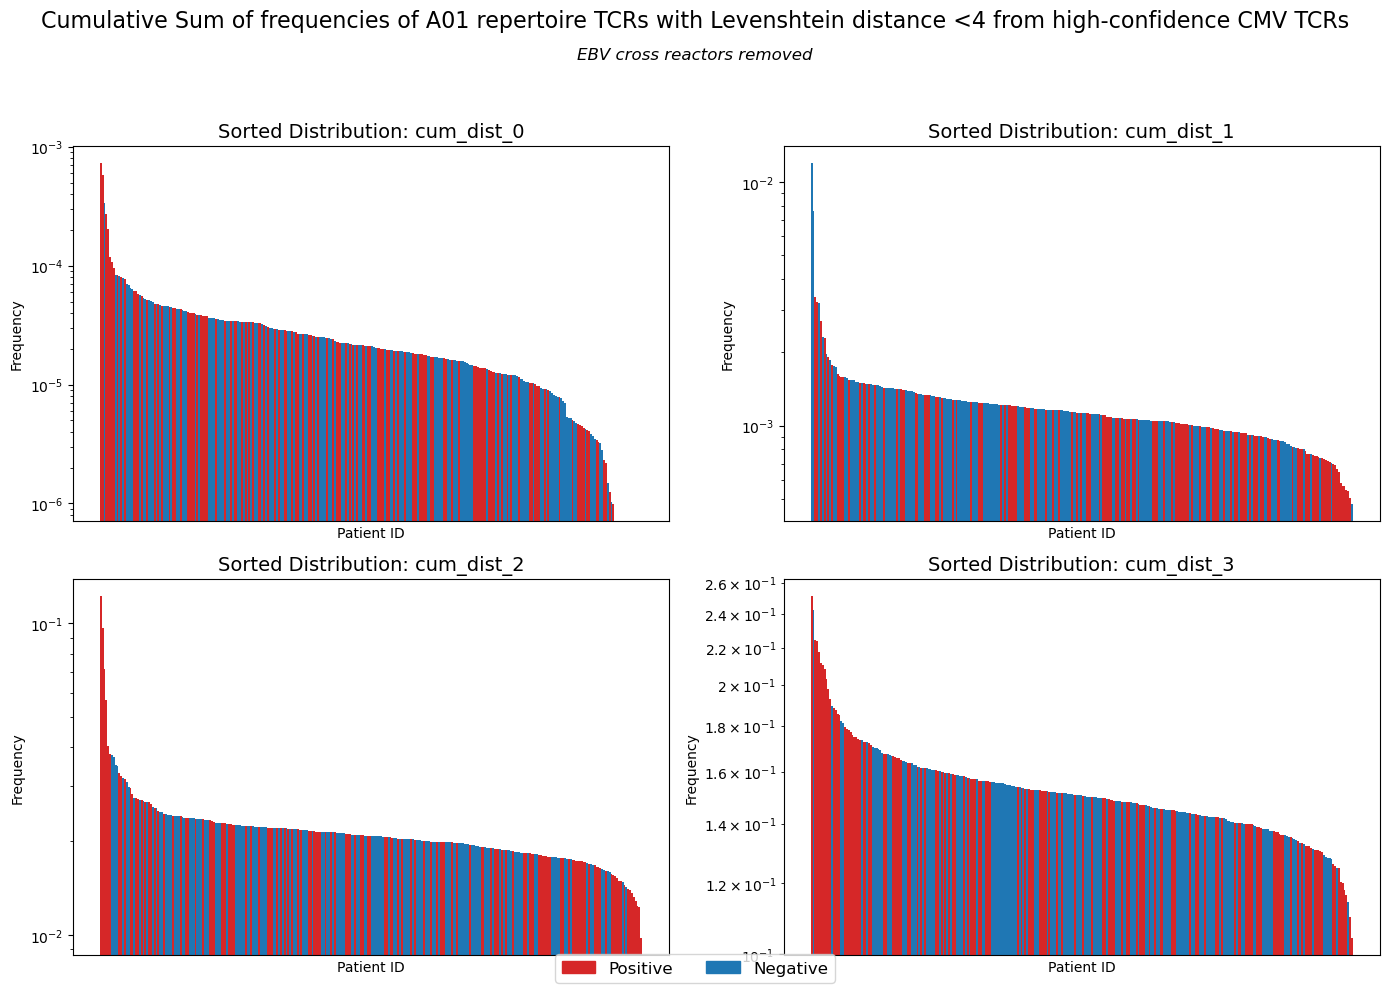

In [31]:
# change this depending on what you want to plot
df = freq_cum_df.copy()


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Columns to plot
dist_cols = ['cum_dist_0', 'cum_dist_1', 'cum_dist_2', 'cum_dist_3']

# Colour map for cmv_status
status_colors = {
    'Positive': 'tab:red',
    'Negative': 'tab:blue'
}

# Create a 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False)
axes = axes.flatten()

for ax, dist in zip(axes, dist_cols):
    # Sort rows by this dist column (largest first)
    df_sorted = df.sort_values(by=dist, ascending=False)
    
    x = df_sorted['patient_id']
    
    y = df_sorted[dist]
    bar_colors = df_sorted['cmv_status'].map(status_colors)
    
    ax.bar(x, y, color=bar_colors, width=1.0)
    ax.set_title(f'Sorted Distribution: {dist}', fontsize=14)
    ax.set_xlabel('Patient ID')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)
    # Remove x axis ticks
    ax.set_xticks([])
    # log y axis
    ax.set_yscale('log')

# Shared title and subtitle
fig.suptitle(f'Cumulative Sum of frequencies of {hla_name} repertoire TCRs with Levenshtein distance <4 from high-confidence CMV TCRs', fontsize=16)
fig.text(0.5, 0.93, f'EBV cross reactors removed', ha='center', fontsize=12, style='italic')

# Shared legend
patches = [mpatches.Patch(color=col, label=status) 
           for status, col in status_colors.items()]
fig.legend(handles=patches, loc='lower center', ncol=len(status_colors), fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
